In [7]:
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score

import preprocessing
import data
import metrics
import parameters
import functions

from time import time

import shap
import matplotlib.pyplot as plt

import joblib

import pandas as pd
import numpy as np

In [8]:
#Data extraction for training model
df = data.data_extraction.BDD_Promo('csv')
#Data Cleaning
df = preprocessing.training_set_preprocessing.training_set_cleaning(df)

In [9]:
def train_validate_model(df):
    #Get data
    X, feature_names = preprocessing.training_set_preprocessing.preco_features(df)
    y, _ = preprocessing.training_set_preprocessing.preco_target(df)
    
    
    #split train, validation and testing data
    #cette partie pourra être remplacée par un CV de la librairie sklearn à posteriori
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.999, random_state=42)
    X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = 0.15, random_state=38)
    
    _,features = preprocessing.training_set_preprocessing.preco_features(df)



    #Reconstructing data Matrix for Model training
    dtrain = xgb.DMatrix(X_train[features], y_train)
    dvalid = xgb.DMatrix(X_valid[features], y_valid)

    watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
    
    
    
    htuning = input('Do you want to perform hyperparameter tuning ? (Y/n)')
    if htuning == 'Y':
        #Model tuning
        print("Performing Grid Search on the model")
        gbm = xgb.XGBRegressor()

        reg = GridSearchCV(gbm, param_grid = xgb_grid, cv = 3, verbose = 2, n_jobs = -1)
        reg.fit(X_train,y_train)
        
        gbm = xgb.train(reg.best_params_, dtrain, num_boost_round = parameters.num_boost_round, evals=watchlist, early_stopping_rounds=parameters.early_stopping_rounds, verbose_eval=50) 
        
    else:
        #Model training
        print("Training a XGBoost model")
        gbm = xgb.train(parameters.xgb_params, dtrain, num_boost_round = parameters.num_boost_round, evals=watchlist, early_stopping_rounds=parameters.early_stopping_rounds, verbose_eval=50)
    

    
    
    #Print performance metrics
    print("\nPerformance on  training set")
    dtest = xgb.DMatrix(X_train[features])
    test_probs = gbm.predict(dtrain)
    error_test = metrics.rmspe(y_train.Ventes.values, test_probs)
    R_squarred = r2_score(y_train.Ventes.values, test_probs)
    adj_2 = metrics.adjusted_r2(feature_names,y_train.Ventes.values, test_probs)
    print('RMSPE: {:.6f}'.format(error_test))
    print('R Squarred: {:.6f}'.format(R_squarred))
    print('R Squarred (adj): {:.6f}'.format(adj_2))
    
    print("\nPerformance on Validation set")
    yhat = gbm.predict(xgb.DMatrix(X_valid[features]))
    error = metrics.rmspe(y_valid.Ventes.values, yhat)
    R_squarred = r2_score(y_valid.Ventes.values, yhat)
    adj_2 = metrics.adjusted_r2(feature_names,y_valid.Ventes.values, yhat)
    print('RMSPE: {:.6f}'.format(error_test))
    print('R Squarred: {:.6f}'.format(R_squarred))
    print('R Squarred (adj): {:.6f}'.format(adj_2))
    
    

    print("\nPerformance on test set")
    dtest = xgb.DMatrix(X_test[features])
    test_probs = gbm.predict(dtest)
    error_test = metrics.rmspe(y_test.Ventes.values, test_probs)
    R_squarred = r2_score(y_test.Ventes.values, test_probs)
    adj_2 = metrics.adjusted_r2(feature_names,y_test.Ventes.values, test_probs)
    print('RMSPE: {:.6f}'.format(error_test))
    print('R Squarred: {:.6f}'.format(R_squarred))
    print('R Squarred (adj): {:.6f}'.format(adj_2))
    
    
    
    # Evaluation metrics
    #------------------- Plot feature importances ----------------
    xgb.plot_importance(booster = gbm, show_values = False, importance_type = 'gain')
    plt.show()
    
    # ------------------- Perform SHAP Analysis on training data --------------------
    #SHAP_Analysis(gbm, X_train, y_train, feature_names)
    
    
    
    if (htuning == 'Y'):
        ask_save_params = input('Do you want to save these hyperparameters ? (Y/n)')
        if (ask_save_params == 'Y'):
            functions.save_obj(reg.best_params_, 'xgb_params' )
   
        

    return gbm, watchlist

Do you want to perform hyperparameter tuning ? (Y/n) n


Training a XGBoost model
[0]	train-rmse:163.388	eval-rmse:177.172
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 100 rounds.
[50]	train-rmse:24.1925	eval-rmse:123.22
[99]	train-rmse:11.6287	eval-rmse:122.671

Performance on  training set
RMSPE: 8.465237
R Squarred: 0.993341
R Squarred (adj): 0.993010

Performance on Validation set
RMSPE: 8.465237
R Squarred: 0.324782
R Squarred (adj): 0.324755

Performance on test set
RMSPE: 59.329255
R Squarred: 0.343210
R Squarred (adj): 0.099260


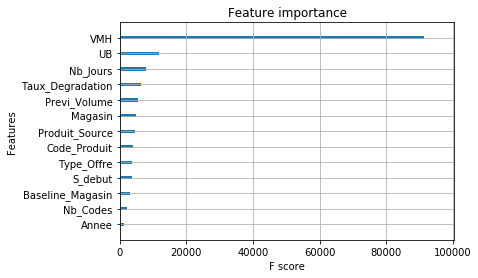

(<xgboost.core.Booster at 0x7f35ad0e9390>,
 [(<xgboost.core.DMatrix at 0x7f35ad0e9e10>, 'train'),
  (<xgboost.core.DMatrix at 0x7f35ad0e98d0>, 'eval')])

In [10]:
train_validate_model(df)